# How is the similarity between Taipei and Kaohsiung?

### Import Libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  55.15 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  36.30 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  40.45 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  49.35 MB/s


In [3]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values 

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.19.0-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  24.37 MB/s
geopy-1.19.0-p 100% |################################| Time: 0:00:00  35.73 MB/s


#### Define Foursquare Credentials and Version


In [4]:
CLIENT_ID = 'ILDTQYVR1TFATLHQJZ05KFKHA1FWNHLGMOUKYXWWA0RNLVK0' # Will's Foursquare ID
CLIENT_SECRET = 'GQLSG1OCZHODGDUM2JJ0QGXP5HPDVDAPERHHVDJ4KZV0RO3Y' # Will Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ILDTQYVR1TFATLHQJZ05KFKHA1FWNHLGMOUKYXWWA0RNLVK0
CLIENT_SECRET:GQLSG1OCZHODGDUM2JJ0QGXP5HPDVDAPERHHVDJ4KZV0RO3Y


## Get Taiwan's Overall Latitude and longitude

In [5]:
!wget -q -O 'taiwan_location.csv' https://github.com/willbearlee/capstone/raw/master/taiwan_location.csv

In [6]:
taiwan_location_df = pd.read_csv('taiwan_location.csv')
taiwan_location_df.head()

,行政區名,_x0033_碼郵遞區號,中心點經度,中心點緯度,TGOS_URL
0,臺北市中正區,100,121.519884,25.032405,http://tgos.nat.gov.tw/tgos/Web/MetaData/TGOS_...
1,臺北市大同區,103,121.513042,25.063424,http://tgos.nat.gov.tw/tgos/Web/MetaData/TGOS_...
2,臺北市中山區,104,121.538160,25.069699,http://tgos.nat.gov.tw/tgos/Web/MetaData/TGOS_...
3,臺北市松山區,105,121.557588,25.059991,http://tgos.nat.gov.tw/tgos/Web/MetaData/TGOS_...
4,臺北市大安區,106,121.543445,25.026770,http://tgos.nat.gov.tw/tgos/Web/MetaData/TGOS_...


In [7]:
taiwan_location_df.columns = ['District', 'DistrictNum', 'Longitude', 'Latitude', 'TGOS_URL']
taiwan_location_df = taiwan_location_df.drop(['TGOS_URL', 'DistrictNum'], axis = 1)                         
#taiwan_location_df.head()

### ===========================Get Taipei Overall Information Data Set===========================

In [8]:
!wget -q -O 'taipei_overall.csv' https://github.com/willbearlee/capstone/raw/master/taipei_overall.csv

In [9]:
taipei_overall_df = pd.read_csv('taipei_overall.csv')  
taipei_overall_df.columns = ['District', 'Plate', 'Reg_1', 'Reg_2', 'Reg_3', 'Households', 'Population' , 'Male', 'Female']
taipei_overall_df.head()
taipei_overall_df = taipei_overall_df.drop(taipei_overall_df.index[0])
taipei_overall_df = taipei_overall_df.drop(['Plate', 'Reg_1', 'Reg_2', 'Reg_3'], axis = 1)
taipei_overall_df['District'] = taipei_overall_df['District'].str.replace(' ','')
taipei_overall_df.head()

,District,Households,Population,Male,Female
1,松山,81217.0,205626.0,96362.0,109264.0
2,信義,89483.0,222814.0,106189.0,116625.0
3,大安,121344.0,308727.0,143896.0,164831.0
4,中山,100450.0,229088.0,106426.0,122662.0
5,中正,65475.0,158814.0,75791.0,83023.0


In [10]:
taipei_overall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 1 to 15
Data columns (total 5 columns):
District      12 non-null object
Households    12 non-null float64
Population    12 non-null float64
Male          12 non-null float64
Female        12 non-null float64
dtypes: float64(4), object(1)
memory usage: 720.0+ bytes


In [11]:
taipei_overall_df.describe()

,Households,Population,Male,Female
count,12.000000,12.000000,12.000000,12.000000
mean,88036.583333,222081.916667,105943.916667,116138.000000
std,23579.252704,63298.273163,29567.174051,33818.551563
min,47371.000000,121379.000000,59289.000000,62090.000000
25%,75441.750000,181492.500000,88444.250000,93048.250000
50%,93443.500000,225951.000000,106307.500000,119643.500000
75%,106957.250000,276686.500000,132580.000000,143946.000000
max,121344.000000,308727.000000,143896.000000,164831.000000


In [13]:
taipei_location_df = taiwan_location_df[taiwan_location_df['District'].str.contains('臺北市')]
taipei_location_df['District'] = taipei_location_df['District'].str.replace('臺北市','')
taipei_location_df['District'] = taipei_location_df['District'].str.replace('區','')

#taipei_location_df.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


#### Merge District and Location Tables

In [14]:
taipei = pd.merge(taipei_overall_df, taipei_location_df, on='District', how='outer')
taipei = taipei.dropna()
taipei['Area'] = 'Taipei'
taipei

,District,Households,Population,Male,Female,Longitude,Latitude,Area
0,松山,81217.0,205626.0,96362.0,109264.0,121.557588,25.059991,Taipei
1,信義,89483.0,222814.0,106189.0,116625.0,121.571670,25.030621,Taipei
2,大安,121344.0,308727.0,143896.0,164831.0,121.543445,25.026770,Taipei
3,中山,100450.0,229088.0,106426.0,122662.0,121.538160,25.069699,Taipei
4,中正,65475.0,158814.0,75791.0,83023.0,121.519884,25.032405,Taipei
5,大同,51881.0,127559.0,62056.0,65503.0,121.513042,25.063424,Taipei
6,萬華,78764.0,189052.0,92662.0,96390.0,121.497986,25.028590,Taipei
7,文山,106781.0,273605.0,131073.0,142532.0,121.573608,24.988579,Taipei
8,南港,47371.0,121379.0,59289.0,62090.0,121.609757,25.036009,Taipei
9,內湖,108783.0,287331.0,137101.0,150230.0,121.592383,25.083706,Taipei


### ===========================Get Kaohsiung Overall Information Data Set===========================

In [15]:
source = requests.get('http://cabu.kcg.gov.tw/Stat/StatRpts/StatRpt1.aspx').text   
soup = BeautifulSoup(source, 'html.parser')

In [16]:
tbody = soup.find('tbody')
District = []
Village = []
Neighborhood = []
Households = []
Population = []
Male = []
Female = []

for index, value in enumerate(tbody.find_all('tr')):
    #print(value.text.strip())
    #print("---------------------------")
    for index, value in enumerate(value.find_all('td')):
        #print(value.text.strip())
        if  (index % 7 == 0):
            District.append(value.text.strip())   
        elif(index % 7 == 1):
            Village.append(value.text.strip())
        elif(index % 7 == 2):
            Neighborhood.append(value.text.strip())
        elif(index % 7 == 3):
            Households.append(value.text.strip())
        elif(index % 7 == 4):
            Population.append(value.text.strip())
        elif(index % 7 == 5):
            Male.append(value.text.strip())
        elif(index % 7 == 6):
            Female.append(value.text.strip())
        else:
            NeighborhoodList.append(value.text.strip())

dataDic = { "District":District, "Village":Village, "Neighborhood": Neighborhood, "Households":Households, "Population":Population, "Male": Male, "Female": Female}
kao_overall_df = pd.DataFrame(dataDic)



In [17]:
# Remove the first total information
kao_overall_df = kao_overall_df.drop(kao_overall_df.index[0])

# Get rid of no use columns
kao_overall_df = kao_overall_df.drop(['Village', 'Neighborhood'], axis = 1)

kao_overall_df.head()

,District,Female,Households,Male,Population
1,鹽埕區,"12,117","10,816","11,924","24,041"
2,鼓山區,"72,702","58,836","67,549","140,251"
3,左營區,"102,479","79,465","94,560","197,039"
4,楠梓區,"94,940","72,210","91,244","186,184"
5,三民一,"39,582","33,036","38,609","78,191"


In [18]:
# Remove the , then to conver to float type
kao_overall_df['District'] = kao_overall_df['District'].str.replace(' ','')
kao_overall_df["Female"] = kao_overall_df['Female'].str.replace(',','')
kao_overall_df["Households"] = kao_overall_df['Households'].str.replace(',','')
kao_overall_df["Male"] = kao_overall_df['Male'].str.replace(',','')
kao_overall_df["Population"] = kao_overall_df['Population'].str.replace(',','')

In [19]:
# to change use .astype() 
kao_overall_df['Female'] = kao_overall_df.Female.astype(float)
kao_overall_df['Male'] = kao_overall_df.Male.astype(float)
kao_overall_df['Households'] = kao_overall_df.Households.astype(float)
kao_overall_df['Population'] = kao_overall_df.Population.astype(float)

In [20]:
kao_overall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 1 to 40
Data columns (total 5 columns):
District      40 non-null object
Female        40 non-null float64
Households    40 non-null float64
Male          40 non-null float64
Population    40 non-null float64
dtypes: float64(4), object(1)
memory usage: 1.9+ KB


In [21]:
kao_overall_df.describe()

,Female,Households,Male,Population
count,40.00000,40.000000,40.000000,40.000000
mean,35050.25000,27528.050000,34289.650000,69339.900000
std,35809.55446,28232.712469,33445.296802,69236.597189
min,981.00000,601.000000,996.000000,1977.000000
25%,11430.75000,8758.750000,11407.750000,22838.500000
50%,18120.50000,13699.000000,18966.000000,37086.500000
75%,50483.00000,36963.250000,50479.250000,100962.250000
max,136473.00000,104110.000000,125937.000000,262410.000000


#### Merge two rows which were separated by original data

In [22]:
Female_1 = kao_overall_df[kao_overall_df['District'].str.contains('鳳山一')]['Female'] 
Female_2 = kao_overall_df[kao_overall_df['District'].str.contains('鳳山二')]['Female'] 
Male_1 = kao_overall_df[kao_overall_df['District'].str.contains('鳳山一')]['Male'] 
Male_2 = kao_overall_df[kao_overall_df['District'].str.contains('鳳山二')]['Male'] 
Households_1 = kao_overall_df[kao_overall_df['District'].str.contains('鳳山一')]['Households'] 
Households_2 = kao_overall_df[kao_overall_df['District'].str.contains('鳳山二')]['Households'] 
Population_1 = kao_overall_df[kao_overall_df['District'].str.contains('鳳山一')]['Population'] 
Population_2 = kao_overall_df[kao_overall_df['District'].str.contains('鳳山二')]['Population'] 

kao_overall_df = kao_overall_df.append({'District': '鳳山區',
                      'Female':int(Female_1) + int(Female_2) ,
                      'Households':int(Male_2)  +  int(Male_2) ,
                      'Male':int(Households_1)  +  int(Households_2) ,
                      'Population':int(Population_1) +  int(Population_2) },
                      ignore_index=True
                     )

In [23]:
Female_1 = kao_overall_df[kao_overall_df['District'].str.contains('三民一')]['Female'] 
Female_2 = kao_overall_df[kao_overall_df['District'].str.contains('三民二')]['Female'] 
Male_1 = kao_overall_df[kao_overall_df['District'].str.contains('三民一')]['Male'] 
Male_2 = kao_overall_df[kao_overall_df['District'].str.contains('三民二')]['Male'] 
Households_1 = kao_overall_df[kao_overall_df['District'].str.contains('三民一')]['Households'] 
Households_2 = kao_overall_df[kao_overall_df['District'].str.contains('三民二')]['Households'] 
Population_1 = kao_overall_df[kao_overall_df['District'].str.contains('三民一')]['Population'] 
Population_2 = kao_overall_df[kao_overall_df['District'].str.contains('三民二')]['Population'] 
 

kao_overall_df = kao_overall_df.append({'District': '三民區',
                      'Female':int(Female_1) + int(Female_2) ,
                      'Households':int(Male_2)  +  int(Male_2) ,
                      'Male':int(Households_1)  +  int(Households_2) ,
                      'Population':int(Population_1) +  int(Population_2) },
                      ignore_index=True
                     )

#### Drop the redundant raws

In [24]:
kao_overall_df = kao_overall_df.drop(4)
kao_overall_df = kao_overall_df.drop(5)
kao_overall_df = kao_overall_df.drop(12)
kao_overall_df = kao_overall_df.drop(13)

In [25]:
kao_overall_df.reset_index(drop=True)

,District,Female,Households,Male,Population
0,鹽埕區,12117.0,10816.0,11924.0,24041.0
1,鼓山區,72702.0,58836.0,67549.0,140251.0
2,左營區,102479.0,79465.0,94560.0,197039.0
3,楠梓區,94940.0,72210.0,91244.0,186184.0
4,新興區,26582.0,23006.0,24515.0,51097.0
5,前金區,14108.0,12727.0,12724.0,26832.0
6,苓雅區,88157.0,72344.0,81347.0,169504.0
7,前鎮區,95706.0,78762.0,92394.0,188100.0
8,旗津區,13805.0,11116.0,14630.0,28435.0
9,小港區,79512.0,68583.0,78259.0,157771.0


In [26]:
# kao_overall_df.head(40)

#### Start to clear the location data

In [27]:
kaohsiung_location_df = taiwan_location_df[taiwan_location_df['District'].str.contains('高雄市')]
kaohsiung_location_df['District'] = kaohsiung_location_df['District'].str.replace('高雄市','')
kaohsiung_location_df.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,District,Longitude,Latitude
257,新興區,120.306734,22.629929
258,前金區,120.294422,22.626991
259,苓雅區,120.320910,22.623594
260,鹽埕區,120.284233,22.624246
261,鼓山區,120.274163,22.650195


#### Merge District and Location Tables

In [28]:
kaohsiung = pd.merge(kao_overall_df, kaohsiung_location_df, on='District', how='outer')
kaohsiung['Area'] = 'Kaohsiung'
kaohsiung

,District,Female,Households,Male,Population,Longitude,Latitude,Area
0,鹽埕區,12117.0,10816.0,11924.0,24041.0,120.284233,22.624246,Kaohsiung
1,鼓山區,72702.0,58836.0,67549.0,140251.0,120.274163,22.650195,Kaohsiung
2,左營區,102479.0,79465.0,94560.0,197039.0,120.295159,22.683957,Kaohsiung
3,楠梓區,94940.0,72210.0,91244.0,186184.0,120.300758,22.721100,Kaohsiung
4,新興區,26582.0,23006.0,24515.0,51097.0,120.306734,22.629929,Kaohsiung
5,前金區,14108.0,12727.0,12724.0,26832.0,120.294422,22.626991,Kaohsiung
6,苓雅區,88157.0,72344.0,81347.0,169504.0,120.320910,22.623594,Kaohsiung
7,前鎮區,95706.0,78762.0,92394.0,188100.0,120.314675,22.592697,Kaohsiung
8,旗津區,13805.0,11116.0,14630.0,28435.0,120.289154,22.585656,Kaohsiung
9,小港區,79512.0,68583.0,78259.0,157771.0,120.359261,22.551402,Kaohsiung


#### Merge Taipei and Kaohsiung Tables together

In [29]:
allTable = pd.concat([kaohsiung, taipei])
allTable.reset_index(drop=True)

,Area,District,Female,Households,Latitude,Longitude,Male,Population
0,Kaohsiung,鹽埕區,12117.0,10816.0,22.624246,120.284233,11924.0,24041.0
1,Kaohsiung,鼓山區,72702.0,58836.0,22.650195,120.274163,67549.0,140251.0
2,Kaohsiung,左營區,102479.0,79465.0,22.683957,120.295159,94560.0,197039.0
3,Kaohsiung,楠梓區,94940.0,72210.0,22.721100,120.300758,91244.0,186184.0
4,Kaohsiung,新興區,26582.0,23006.0,22.629929,120.306734,24515.0,51097.0
5,Kaohsiung,前金區,14108.0,12727.0,22.626991,120.294422,12724.0,26832.0
6,Kaohsiung,苓雅區,88157.0,72344.0,22.623594,120.320910,81347.0,169504.0
7,Kaohsiung,前鎮區,95706.0,78762.0,22.592697,120.314675,92394.0,188100.0
8,Kaohsiung,旗津區,13805.0,11116.0,22.585656,120.289154,14630.0,28435.0
9,Kaohsiung,小港區,79512.0,68583.0,22.551402,120.359261,78259.0,157771.0


### Compare the population

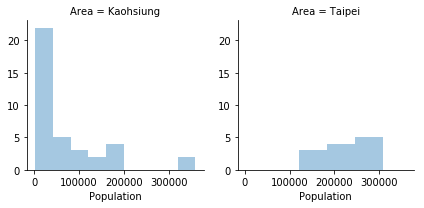

In [30]:
g = sns.FacetGrid(allTable, col = 'Area')
g.map(sns.distplot, 'Population', kde = False)

### Compare the Female


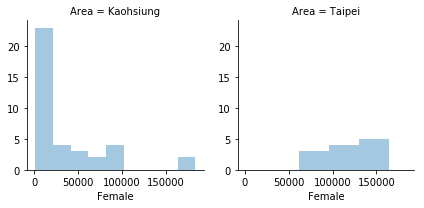

In [31]:
g = sns.FacetGrid(allTable, col = 'Area')
g.map(sns.distplot, 'Female', kde = False)

### Compare the Male

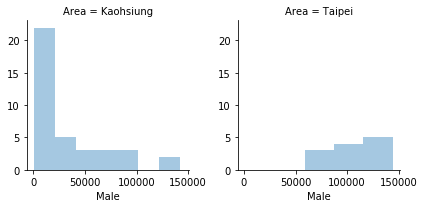

In [32]:
g = sns.FacetGrid(allTable, col = 'Area')
g.map(sns.distplot, 'Male', kde = False)

### Compare the Households

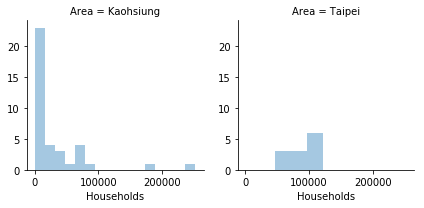

In [33]:
g = sns.FacetGrid(allTable, col = 'Area')
g.map(sns.distplot, 'Households', kde = False)

#### Get the Malvern's neighborhood's name.First, let's create the GET request URL. Name your URL url.

In [34]:
neighborhood_latitude = kaohsiung.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = kaohsiung.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = kaohsiung.loc[0, 'District'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of 鹽埕區 are 22.62424585, 120.2842331.


#### First, let's create the GET request URL. Name your URL url.

In [35]:
# The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API


radius = 500 # define radius


# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=ILDTQYVR1TFATLHQJZ05KFKHA1FWNHLGMOUKYXWWA0RNLVK0&client_secret=GQLSG1OCZHODGDUM2JJ0QGXP5HPDVDAPERHHVDJ4KZV0RO3Y&v=20180605&ll=22.62424585,120.2842331&radius=500&limit=100'

In [36]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c9ea6c24c1f672901129138'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4c2f18e5213c2d7fe743305d-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bubble_',
          'suffix': '.png'},
         'id': '52e81612bcbc57f1066b7a0c',
         'name': 'Bubble Tea Shop',
         'pluralName': 'Bubble Tea Shops',
         'primary': True,
         'shortName': 'Bubble Tea'}],
       'id': '4c2f18e5213c2d7fe743305d',
       'location': {'address': '鹽埕區新樂街99號',
        'cc': 'TW',
        'city': '高雄市',
        'country': '臺灣',
        'crossStreet': '總店',
        'distance': 181,
        'formattedAddress': ['鹽埕區新樂街99號 (總店)', '高雄市,  803', '臺灣'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 22.62368868890724,
       

#### From the Foursquare lab in the previous module, we know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.


In [37]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Now we are ready to clean the json and structure it into a pandas dataframe.¶

#### Let's create a function to repeat the same process to all the neighborhoods in Taipei

In [38]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


In [39]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,樺達奶茶 Huada Milk Tea,Bubble Tea Shop,22.623689,120.285895
1,Harbour Cantonese Restaurant (港都茶樓),Dim Sum Restaurant,22.625067,120.285676
2,貢茶 Gong Cha,Bubble Tea Shop,22.623695,120.283789
3,米糕城,Chinese Restaurant,22.625669,120.284351
4,高雄婆婆冰,Ice Cream Shop,22.626357,120.282227


#### And how many venues were returned by Foursquare?

In [40]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


32 venues were returned by Foursquare.


## Explore Neighborhoods in Kaohsiung

In [41]:
#### Let's create a function to repeat the same process to all the neighborhoods in

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_fsa.

In [43]:
# type your answer here

kaohsiung_venues = getNearbyVenues(names=kaohsiung['District'],
                                   latitudes=kaohsiung['Latitude'],
                                   longitudes=kaohsiung['Longitude']
                                  )

鹽埕區
鼓山區
左營區
楠梓區
新興區
前金區
苓雅區
前鎮區
旗津區
小港區
林園區
大寮區
大樹區
大社區
仁武區
鳥松區
岡山區
橋頭區
燕巢區
田寮區
阿蓮區
路竹區
湖內區
茄萣區
永安區
彌陀區
梓官區
旗山區
美濃區
六龜區
甲仙區
杉林區
內門區
茂林區
桃源區
那瑪夏區
鳳山區
三民區


#### Let's check the size of the resulting dataframe

In [44]:
print(kaohsiung.shape)
kaohsiung_venues.head()

(38, 8)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,鹽埕區,22.624246,120.284233,樺達奶茶 Huada Milk Tea,22.623689,120.285895,Bubble Tea Shop
1,鹽埕區,22.624246,120.284233,Harbour Cantonese Restaurant (港都茶樓),22.625067,120.285676,Dim Sum Restaurant
2,鹽埕區,22.624246,120.284233,貢茶 Gong Cha,22.623695,120.283789,Bubble Tea Shop
3,鹽埕區,22.624246,120.284233,米糕城,22.625669,120.284351,Chinese Restaurant
4,鹽埕區,22.624246,120.284233,高雄婆婆冰,22.626357,120.282227,Ice Cream Shop


In [45]:
#### Let's check how many venues were returned for each neighborhood

In [46]:
kaohsiung_venues.groupby('District').count()


,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
三民區,7,7,7,7,7,7
前金區,10,10,10,10,10,10
前鎮區,4,4,4,4,4,4
岡山區,2,2,2,2,2,2
左營區,10,10,10,10,10,10
新興區,13,13,13,13,13,13
旗津區,2,2,2,2,2,2
梓官區,2,2,2,2,2,2
楠梓區,3,3,3,3,3,3


#### Let's find out how many unique categories can be curated from all the returned venues

In [47]:
print('There are {} uniques categories.'.format(len(kaohsiung_venues['Venue Category'].unique())))


There are 54 uniques categories.


In [48]:
kaohsiung_venues['Area'] = 'Kaohsiung'


#### Analyze Each Neighborhood


#### Start to retrieve Venues infor of Taipei

In [49]:
taipei_venues = getNearbyVenues(names=taipei['District'],
                                   latitudes=taipei['Latitude'],
                                   longitudes=taipei['Longitude']
                                  )

松山
信義
大安
中山
中正
大同
萬華
文山
南港
內湖
士林
北投


In [50]:
taipei_venues['Area'] = 'Taipei'
taipei_venues

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Area
0,松山,25.059991,121.557588,SunnyHills (微熱山丘),25.057776,121.557175,Pastry Shop,Taipei
1,松山,25.059991,121.557588,Fujin Tree 353 Cafe by Simple Kaffa,25.060595,121.557873,Café,Taipei
2,松山,25.059991,121.557588,Beams Taipei,25.060525,121.557175,Clothing Store,Taipei
3,松山,25.059991,121.557588,台南財神担仔麵,25.058373,121.560571,Taiwanese Restaurant,Taipei
4,松山,25.059991,121.557588,集品文創 Design Butik,25.058349,121.557008,Furniture / Home Store,Taipei
5,松山,25.059991,121.557588,Beauty & Youth United Arrows,25.058922,121.556662,Clothing Store,Taipei
6,松山,25.059991,121.557588,戴記涼麵,25.060799,121.561323,Noodle House,Taipei
7,松山,25.059991,121.557588,正宗青島水餃,25.060819,121.561530,Dumpling Restaurant,Taipei
8,松山,25.059991,121.557588,有時候紅豆餅,25.056406,121.557283,Snack Place,Taipei
9,松山,25.059991,121.557588,All Day Roasting Company,25.056569,121.560347,Café,Taipei
